In [2]:
import os
os.chdir("..")
!pwd

/datasets/home/home-00/10/410/rcgonzal/DSC180Malware/m2v-adversarial-hindroid


In [3]:
!pip install stellargraph
!pip install p_tqdm

Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable


In [1]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import os
import networkx as nx
import numpy as np
import pandas as pd
from stellargraph import datasets
from IPython.display import display, HTML
from gensim.models import Word2Vec
from stellargraph.data import UniformRandomMetaPathWalk
from stellargraph import StellarGraph, IndexedArray
import json
from collections import defaultdict
from p_tqdm import p_umap


%matplotlib inline

In [4]:
all_apps = pd.read_csv("data/out/all-apps/all_apps.csv")
all_apps[all_apps.category=='random-apps'].to_csv('data/out/random-apps/app_list.csv')

In [2]:
dataset = datasets.BlogCatalog3()
display(HTML(dataset.description))
g = dataset.load()
print(
    "Number of nodes {} and number of edges {} in graph.".format(
        g.number_of_nodes(), g.number_of_edges()
    )
)

Number of nodes 10351 and number of edges 348459 in graph.


In [11]:
walk_length = 100  # maximum length of a random walk to use throughout this notebook

# specify the metapath schemas as a list of lists of node types.
metapaths = [
    ["user", "group", "user"],
    ["user", "group", "user", "user"],
    ["user", "user"],
]

In [12]:
UniformRandomMetaPathWalk?

In [7]:
# Create the random walker
rw = UniformRandomMetaPathWalk(g)

walks = rw.run(
    nodes=list(g.nodes()),  # root nodes
    length=walk_length,  # maximum length of a random walk
    n=1,  # number of random walks per root node
    metapaths=metapaths,  # the metapaths
)

print("Number of random walks: {}".format(len(walks)))

Number of random walks: 30936


UniformRandomMetaPathWalk algorithm:

Given:
- $n$ walks per node
- length of each random walk
- a list of metapaths
- a list of nodes

for each node

    for each metapath
    
    metapath = metapath[1:] * ((length // (len(metapath) - 1)) + 1)
    
        for n walks:
        
            for d in length:
            
                record current node
                
                find neighbors of current node of type metapath[d]
                
                randomly select new node from neighbors
                

In [14]:
%%timeit -n 1
model = Word2Vec(walks, size=128, window=5, min_count=0, sg=1, workers=9, iter=1)
model.wv.vectors.shape  # 128-dimensional vector for each node in the graph

NameError: name 'walks' is not defined

In [2]:
from dask.distributed import Client
import dask.dataframe as dd
import os
import pandas as pd
import numpy as np
from stellargraph import StellarGraph, IndexedArray
from stellargraph.data import UniformRandomMetaPathWalk
from gensim.models import Word2Vec

client = Client()

In [7]:
path = os.path.join('data/out/random-apps/app-data/', '*.csv')
data = dd.read_csv(path)

In [19]:
outfolder = os.path.join("data/out/random-apps/")

nodes = {}
api_map = None
edge_path = os.path.join("data/out/random-apps/edges.csv")
pd.DataFrame(columns=['source', 'target']).to_csv(edge_path, index=False)
for label in ['api', 'app', 'method', 'package']:
    print(f'Indexing {label}s')
    uid_map = data[label].unique().compute()
    uid_map = uid_map.to_frame()
    uid_map['uid'] = label + pd.Series(uid_map.index).astype(str)
    uid_map = uid_map.set_index(label)
    uid_map.to_csv(os.path.join(outfolder, label+'_map.csv'))
    nodes[label] = IndexedArray(index=uid_map.uid.values)
    
    # get edges if not api
    if label == 'api':
        api_map = uid_map.uid
    else:
        print(f'Finding {label}-api edges')
        edges = data[[label, 'api']].drop_duplicates().compute()
        edges[label] = edges[label].map(uid_map.uid)
        edges['api'] = edges['api'].map(api_map)
        edges.to_csv(edge_path, mode='a', index=False, header=False)

Indexing apis
Indexing apps
Finding app-api edges
Indexing methods
Finding method-api edges
Indexing packages
Finding package-api edges


In [20]:
g = StellarGraph(nodes = nodes,
                 edges = pd.read_csv(edge_path))

In [21]:
list(pd.read_csv(os.path.join("data/out/random-apps/", 'app_map.csv')).uid)

,app,uid
0,academia_en_tu_movil.test_guarda_rural,app0
1,air.G2JWeirdKittyRescue,app1
2,air.com.adobe.example.gqbars,app2
3,air.com.eeco.blocknflick,app3
4,air.com.inline.jyoyuuman1,app4
...,...,...
227,sl_christmas_free.livewallpaper,app227
228,taha.islam.renewal,app228
229,toolbox.m.incoming.stop,app229
230,ua.com.citysites.belorechensk,app230


In [22]:
walk_length = 100  # maximum length of a random walk to use throughout this notebook

# specify the metapath schemas as a list of lists of node types.
metapaths = [
    ['app', 'api', 'app'],
    ['app', 'api', 'method', 'api', 'app']
]

# Create the random walker
rw = UniformRandomMetaPathWalk(g)

walks = rw.run(
    nodes=list(list(pd.read_csv(os.path.join("data/out/random-apps/", 'app_map.csv')).uid)),  # root nodes
    length=walk_length,  # maximum length of a random walk
    n=1,  # number of random walks per root node
    metapaths=metapaths,  # the metapaths
)

print("Number of random walks: {}".format(len(walks)))

model = Word2Vec(walks, size=128, window=5, min_count=0, sg=1, workers=9, iter=1)
model.wv.vectors.shape  # 128-dimensional vector for each node in the graph

Number of random walks: 464


(25084, 128)

In [60]:
Word2Vec?

In [55]:
vectors = pd.DataFrame(model.wv.vectors)
vectors['uid'] = model.wv.index2word
vectors = vectors[vectors.uid.str.contains('app')].set_index('uid')
vectors

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
uid,,,,,,,,,,,,,,,,,,,,,
app15,0.001465,-0.006035,0.002803,-0.006472,0.001844,0.000563,0.000152,0.004515,-0.004373,-0.005861,...,0.000944,-0.001850,0.005967,0.005115,0.001456,-0.005741,-0.004002,0.001943,-0.000393,0.002028
app222,-0.007221,0.003152,0.001400,0.001215,-0.004036,-0.000574,-0.002065,-0.004598,-0.002774,0.001391,...,0.002566,-0.005518,-0.001023,0.002259,-0.003552,0.004228,-0.003225,0.002905,0.001139,-0.005657
app218,-0.006554,-0.002982,-0.002722,-0.005685,-0.002853,-0.001394,-0.002546,-0.001562,0.000574,0.001690,...,0.006558,-0.005123,-0.003411,-0.000147,0.000418,0.004349,-0.002708,0.003058,-0.001097,-0.005037
app165,-0.005208,0.002826,-0.003647,-0.001873,-0.001584,-0.002434,-0.003195,-0.002779,0.000455,-0.004313,...,0.003347,-0.002185,-0.003458,0.003372,0.002375,0.003374,-0.003633,-0.002255,0.000983,0.001666
app28,-0.005466,-0.003686,0.002009,0.001212,-0.003348,-0.003617,-0.000823,0.002770,-0.003804,0.001141,...,0.004744,0.002535,0.002379,0.001448,-0.001578,-0.000589,-0.003026,-0.004600,-0.000578,-0.000055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
app227,0.001438,0.000468,-0.001837,-0.000628,-0.002511,-0.003152,-0.003805,0.000339,-0.001998,0.001987,...,-0.002464,-0.002573,-0.003751,0.002902,-0.003180,-0.001320,0.002686,0.001412,0.000844,0.003542
app219,-0.000863,0.001027,-0.002669,-0.001507,-0.003353,0.002642,-0.002374,0.002786,-0.000703,0.002141,...,-0.001145,0.002694,-0.000156,-0.000077,-0.003835,0.000177,0.003179,0.000310,0.002191,-0.000920
app205,-0.000185,-0.003573,-0.002284,0.003279,-0.003176,0.001420,0.003164,-0.000256,0.003811,-0.000799,...,0.002207,0.002723,0.001734,0.002099,-0.000410,-0.001579,-0.001346,0.000726,0.001925,0.003099


In [56]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from IPython.display import display, HTML

In [57]:
# Retrieve node embeddings and corresponding subjects
node_ids = list(vectors.index)  # list of node IDs
node_embeddings = (
    vectors.values
)  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = [g.node_type(node_id) for node_id in node_ids]

In [58]:
transform = TSNE  # PCA

trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(node_embeddings)

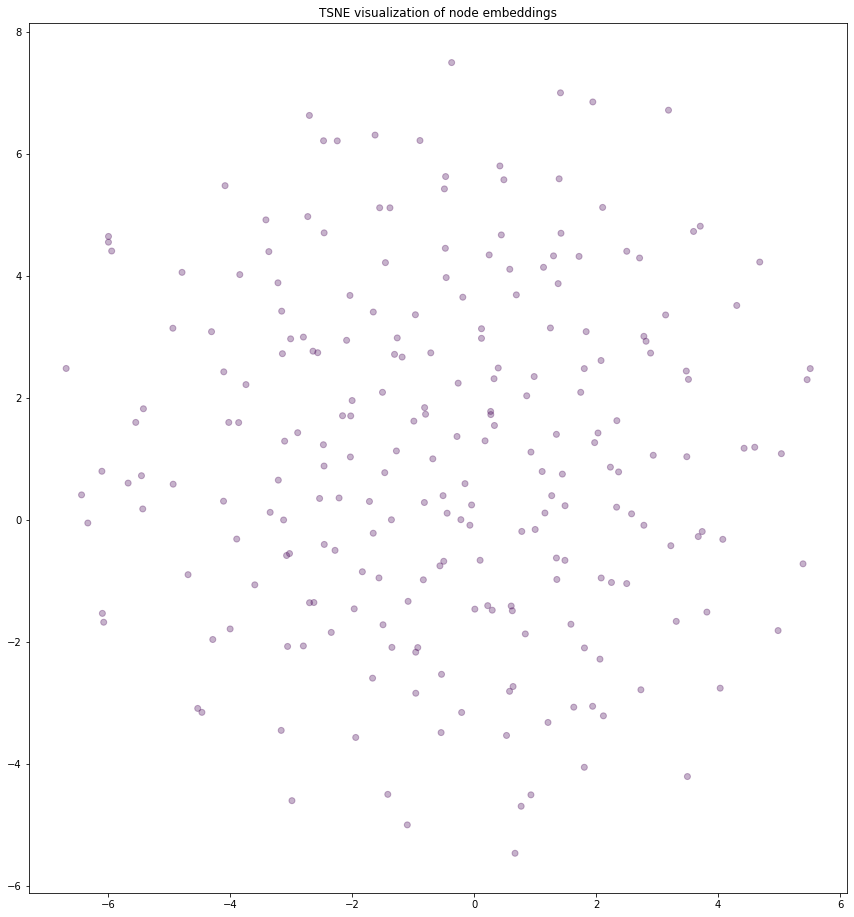

In [59]:
# draw the points
label_map = {l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [label_map[target] for target in node_targets]

plt.figure(figsize=(20, 16))
plt.axes().set(aspect="equal")
plt.scatter(node_embeddings_2d[:, 0], node_embeddings_2d[:, 1], c=node_colours, alpha=0.3)
plt.title("{} visualization of node embeddings".format(transform.__name__))
plt.show()

In [27]:
import pickle

In [29]:
outfolder

'data/out/random-apps/'

In [39]:
with open(os.path.join(outfolder, 'graph.pkl'), 'wb') as file:
    pickle.dump(g, file)

In [41]:
with open(os.path.join(outfolder, 'graph.pkl'), 'rb') as file:
    pickle.load(file)

In [ ]:
os.path.exists()